In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [8]:
batch_size = 50
epoch_num = 15
learning_rate = 1e-4

In [9]:
train_data = datasets.MNIST(root = './data', train = True, download = True,
                           transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './data', train = False,
                          transform = transforms.ToTensor())
print('number of train_data : ', len(train_data))
print('number of test_data : ', len(test_data))

number of train_data :  60000
number of test_data :  10000


C:\Users\Administrator\anaconda3\envs\AAI_2021\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


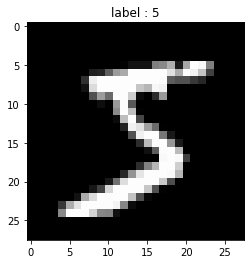

In [10]:
image, label = train_data[0]

plt.imshow(image.squeeze().numpy(), cmap = 'gray') #squeeze : 크기가 1인 차원을 없애줌
plt.title('label : %s' %label)
plt.show()

In [17]:
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                          batch_size = batch_size,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                         batch_size = batch_size,
                                         shuffle = True)

first_batch = train_loader.__iter__().__next__()
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first batch[1]', str(type(first_batch[1])), first_batch[1].shape))

name            | type                      | size
Num of batch    |                           | 1200
first batch     | <class 'list'>            | 2
first batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


In [18]:
class CNN(nn.Module): # nn.Module 클래스를 상속받는 CNN 클래스를 정의
    def __init__(self): # __init__를 통해 모델에서 사용되는 가중치를 정의
        super(CNN, self).__init__() # supter() 함수를 통해 nn.Module 클래스의 속성을 상속받고 초기화
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1) # in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1
        self.dropout1 = nn.Dropout2d(0.25) # 0.25확률인 Dropout
        self.dropout2 = nn.Dropout2d(0.5) # 0.5 확률인 Dropout
        self.fc1 = nn.Linear(9216, 128) # Fully-connected Layer 9216크기인 벡터를 128 크기의 백터로 변환하는 가중치를 설계
        self.fc2 = nn.Linear(128, 10) # Mnist의 클래스 개수인 10 크기의 벡터로 변환하는 가중치
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x) # ReLU 활성 함수를 적용. 활성 함수는 단순 연산이므로. __init__에서 정의한 학습 가중치가 없음
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # (2x2)크기의 Filter로 Max Pooling을 적용.
        x = self.dropout1(x)
        x = torch.flatten(x, 1) # 고차원의 Tensor을 1차원의 벡터로 변환
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim = 1) # 최종 출력값으로 log-softmax를 계산, Softmax함수가 아닌, log_softmax()를 사용 하면 연산속도를 높일 수 있음
        return output

In [19]:
model = CNN().to(device) # CNN 클래스를 이용해 model이라는 인스턴스를 생성. 코드 상단에 지정한 연산 장비 device를 인식
optimizer = optim.Adam(model.parameters(), lr = learning_rate) # Adam 알고리즘의 optimizer를 지정
criterion = nn.CrossEntropyLoss() # Cross Entropy를 손실 함수로 지정 - 다중 클래스 분류 문제이기 때문에

In [20]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [22]:
model.train()
i = 0
import timeit
 
start_time = timeit.default_timer() 
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)     # 미니 배치의 데이터를 기존에 지정한 장비 device에 할당
        target = target.to(device) # 미니 배치의 정답를 기존에 지정한 장비 device에 할당
        optimizer.zero_grad() # 학습을 시작하기 전, 이전 반복 시행에서 저장된 optimizer의 Gradient를 초기화함
        output = model(data) # Feed Forward 연산으로 결과값을 계산
        loss = criterion(output, target) # 계산된 결과값과 실제 정답으로 손실 함수를 계산
        loss.backward() # 손실 함수를 통해 Gradient를 계산
        optimizer.step() # 위에서 계산된 Gradient를 통해 모델의 가중치를 업데이트 함
        if i % 1000 == 0:
            print('Train Step: {}\tLoss: {:.3f}'.format(i, loss.item()))
        i += 1
terminate_time = timeit.default_timer()
print("%f초 걸렸습니다." % (terminate_time - start_time)) 

Train Step: 0	Loss: 0.027
Train Step: 1000	Loss: 0.007
Train Step: 2000	Loss: 0.073
Train Step: 3000	Loss: 0.014
Train Step: 4000	Loss: 0.008
Train Step: 5000	Loss: 0.007
Train Step: 6000	Loss: 0.003
Train Step: 7000	Loss: 0.005
Train Step: 8000	Loss: 0.021
Train Step: 9000	Loss: 0.009
Train Step: 10000	Loss: 0.007
Train Step: 11000	Loss: 0.003
Train Step: 12000	Loss: 0.062
Train Step: 13000	Loss: 0.001
Train Step: 14000	Loss: 0.056
Train Step: 15000	Loss: 0.006
Train Step: 16000	Loss: 0.007
Train Step: 17000	Loss: 0.020
141.658825초 걸렸습니다.


In [25]:
model.eval() # 평가 모드를 싱행하기 위해 명시. eval() 호출하면, Dropout이 적용되지 않고 Batch-Normalization도 평가 모드로 전환
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1] # Log-Softmax 값이 가장 큰 인덱스를 예측값으로 저장
    correct += prediction.eq(target.data).sum() # 실제 정답 예측값이 같으면 True, 다르면 False인 논리값으로 구성된 벡터를 더함.
    # 즉, 미니 배치중 정답의 개수를 구하고 반복 시행마다 누적해서 더함
    
print('Test set: Accuracy: {:.2f}%'.format(100*correct/len(test_loader.dataset)))

Test set: Accuracy: 99.12%
